In [1]:
import numpy as np
import pandas as pd
import glob
import PIL.Image
import matplotlib.pyplot as plt

PTH='/home/lauh/projects/def-gambsseb/lauh/latent_space/'

In [2]:
def get_w_trgt_proj(folder):
    w_list=[]
    target_list=[]
    proj_list=[]
    img_folder= glob.glob(PTH+'{}/*'.format(folder))
    for subfolder in img_folder:
        for img_pth in glob.glob(subfolder+'/*'):
            data= np.load(img_pth+'/projected_z.npz')
            w= data['z']
            w_list.append(w[0])
            target_list.append(np.array(PIL.Image.open(img_pth+'/target.png'))/255.)
            proj_list.append(np.array(PIL.Image.open(img_pth+'/proj.png'))/255.)
    return np.vstack(w_list), np.stack(target_list), np.stack(proj_list)

w_member, target_member, proj_member=get_w_trgt_proj('z_member')
w_non_member, target_non_member, proj_non_member=get_w_trgt_proj('z_non_member')
#w_attack, target_attack, proj_attack=get_w_trgt_proj('w_attack')

In [3]:
def compute_l2(target, proj):
    l2=[]
    for i in range(len(target)):
        l2.append(np.sqrt(np.sum((target[i]-proj[i])**2)))
    return l2

l2_member= compute_l2(target_member, proj_member)
l2_non_member= compute_l2(target_non_member, proj_non_member)
#l2_attack= compute_l2(target_attack, proj_attack)


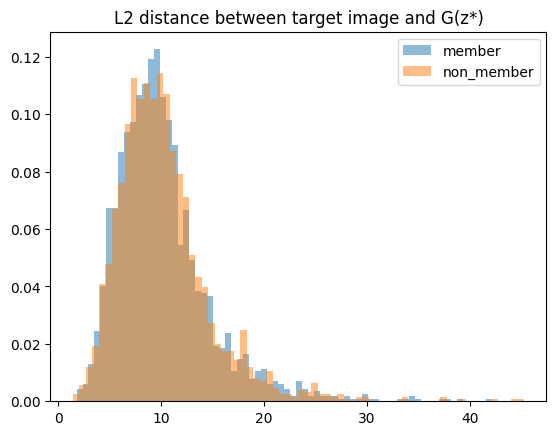

avg l2 reconstruction member 10.21949935507688
avg l2 reconstruction non_member 10.267759137240175


In [4]:


plt.hist(l2_member, density=True, label='member', alpha=.5, bins=70)
plt.hist(l2_non_member, density=True, label='non_member', alpha=.5, bins=70)
#plt.hist(l2_attack, density=True, label='attack', alpha=.1, bins=10)
plt.title('L2 distance between target image and G(z*)')
plt.legend()
plt.show()

print('avg l2 reconstruction member', np.mean(l2_member))
print('avg l2 reconstruction non_member', np.mean(l2_non_member))

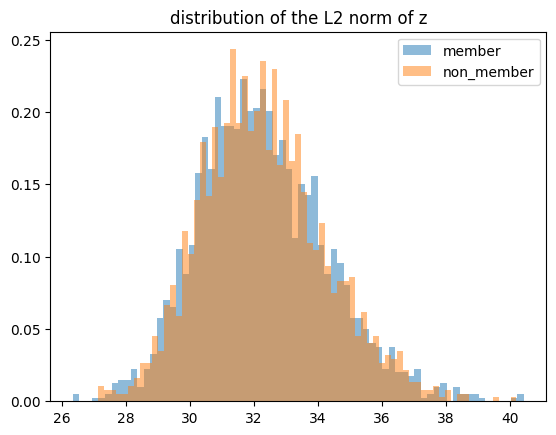

In [5]:
#norm_attack=np.linalg.norm(w_attack, axis=1)
norm_member=np.linalg.norm(w_member, axis=1)
norm_non_member=np.linalg.norm(w_non_member, axis=1)

plt.hist(norm_member, density=True, label='member', alpha=.5, bins=70)
plt.hist(norm_non_member, density=True, label='non_member', alpha=.5, bins=70)
#plt.hist(norm_attack, density=True, label='attack', alpha=.1, bins=10)
plt.title('distribution of the L2 norm of z')
plt.legend()
plt.show()

In [6]:
print('avg l2 norm w member:', np.mean(norm_member))
print('avg l2 norm w non member:', np.mean(norm_non_member))

avg l2 norm w member: 32.279305
avg l2 norm w non member: 32.29768


In [15]:
df_member= pd.DataFrame({'reconstruction_l2': l2_member, 'w_l2': norm_member, 'member':[1 for i in range(len(l2_member))]})
df_non_member= pd.DataFrame({'reconstruction_l2': l2_non_member, 'w_l2': norm_non_member, 'member':[0 for i in range(len(l2_non_member))]})
df= pd.concat([df_member, df_non_member], axis =0, ignore_index=True)
threshold= df.w_l2.quantile(.01)
df.loc[df.w_l2<= threshold,'member'].mean()

0.6

In [16]:
df.loc[df.w_l2<= threshold,'member'].shape

(40,)

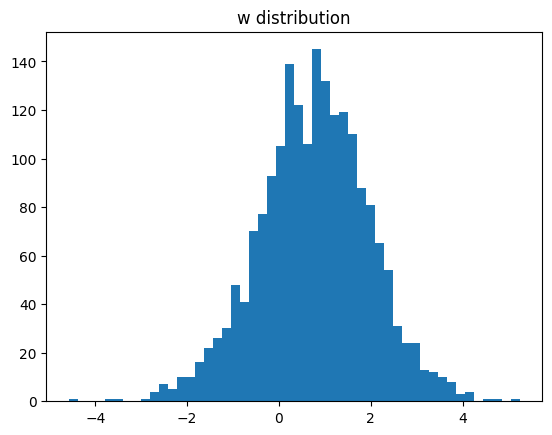

In [9]:
plt.hist(w_member[:,1], bins=50)
plt.title('w distribution')
plt.show()

# VGG

In [6]:
NETWORK_PTH= '/home/lauh/projects/def-gambsseb/lauh/latent_space/00000-cifar10_mini-cond-cifar/network-snapshot-004032.pkl'
import dnnlib
import legacy
import torch

device = torch.device('cuda')

with dnnlib.util.open_url(NETWORK_PTH) as fp:
        G = legacy.load_network_pkl(fp)['G_ema'].requires_grad_(False).to(device)

url = 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/metrics/vgg16.pt'
with dnnlib.util.open_url(url) as f:
    vgg16 = torch.jit.load(f).eval().to(device)


In [26]:
def get_trgt_proj_VGG(folder):
    target_list=[]
    proj_list=[]
    img_folder= glob.glob(PTH+'{}/*'.format(folder))
    for subfolder in img_folder:
        for img_pth in glob.glob(subfolder+'/*'):
            target_list.append(PIL.Image.open(img_pth+'/target.png'))
            proj_list.append(PIL.Image.open(img_pth+'/proj.png'))
    return target_list, proj_list

target_member, proj_member=get_trgt_proj_VGG('z_member')
target_non_member, proj_non_member=get_trgt_proj_VGG('z_non_member')

In [29]:
def extract_VGG_features(img_list):
    features_list=[]
    for target_pil in img_list:
        w, h = target_pil.size
        s = min(w, h)
        target_pil = target_pil.crop(((w - s) // 2, (h - s) // 2, (w + s) // 2, (h + s) // 2))
        target_pil = target_pil.resize((G.img_resolution, G.img_resolution), PIL.Image.LANCZOS)
        target_uint8 = np.array(target_pil, dtype=np.uint8)
        target=torch.tensor(target_uint8.transpose([2, 0, 1]), device=device)
        target_images = target.unsqueeze(0).to(device).to(torch.float32)
        if target_images.shape[2] > 256:
            target_images = F.interpolate(target_images, size=(256, 256), mode='area')
        target_features = vgg16(target_images, resize_images=False, return_lpips=True)
        features_list.append(target_features)
    return torch.cat(features_list, axis=0)


target_member_vgg= extract_VGG_features(target_member)
proj_member_vgg=extract_VGG_features(proj_member)
target_non_member_vgg=extract_VGG_features(target_non_member)
proj_non_member_vgg=extract_VGG_features(proj_non_member)

In [30]:
member_vgg_dist= (target_member_vgg-proj_member_vgg).square().sum(axis=1).cpu().numpy()
non_member_vgg_dist= (target_non_member_vgg-proj_non_member_vgg).square().sum(axis=1).cpu().numpy()

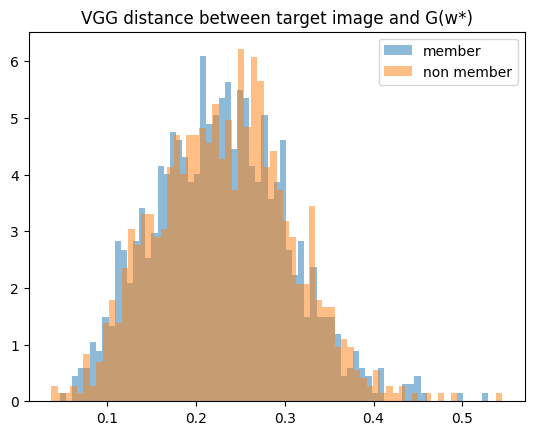

In [31]:
plt.hist(member_vgg_dist, label= 'member', alpha=.5, bins=70, density=True)
plt.hist(non_member_vgg_dist, label= 'non member', alpha=.5, bins=70, density=True)
plt.title('VGG distance between target image and G(w*)')
plt.legend()
plt.show()

# Noise Stability

In [7]:
import json
with open('/scratch/lauh/cifar10_membership/dataset.json') as f:
    labels_dict_raw = json.load(f)

In [8]:
labels_dict={}
for i in labels_dict_raw['labels']:
    labels_dict[i[0]]=i[1]
labels_dict

{'00000/img00000000.png': 6,
 '00000/img00000001.png': 9,
 '00000/img00000002.png': 9,
 '00000/img00000003.png': 4,
 '00000/img00000004.png': 1,
 '00000/img00000005.png': 1,
 '00000/img00000006.png': 2,
 '00000/img00000007.png': 7,
 '00000/img00000008.png': 8,
 '00000/img00000009.png': 3,
 '00000/img00000010.png': 4,
 '00000/img00000011.png': 7,
 '00000/img00000012.png': 7,
 '00000/img00000013.png': 2,
 '00000/img00000014.png': 9,
 '00000/img00000015.png': 9,
 '00000/img00000016.png': 9,
 '00000/img00000017.png': 3,
 '00000/img00000018.png': 2,
 '00000/img00000019.png': 6,
 '00000/img00000020.png': 4,
 '00000/img00000021.png': 3,
 '00000/img00000022.png': 6,
 '00000/img00000023.png': 6,
 '00000/img00000024.png': 2,
 '00000/img00000025.png': 6,
 '00000/img00000026.png': 3,
 '00000/img00000027.png': 5,
 '00000/img00000028.png': 4,
 '00000/img00000029.png': 0,
 '00000/img00000030.png': 0,
 '00000/img00000031.png': 9,
 '00000/img00000032.png': 1,
 '00000/img00000033.png': 3,
 '00000/img000

In [9]:


def get_w_full(folder, labels_dict):
    w_list=[]
    img_folder= glob.glob(PTH+'{}/*'.format(folder))
    for subfolder in img_folder:
        for img_pth in glob.glob(subfolder+'/*'):
            data= np.load(img_pth+'/projected_z.npz')
            w= data['z']
            k= '/'.join(img_pth.split('/')[-2:])
            label= labels_dict[k]
            w_list.append([torch.Tensor(w),label])
    return w_list

z_member=get_w_full('z_member', labels_dict)
z_non_member=get_w_full('z_non_member', labels_dict)


In [14]:
torch.manual_seed(42)


In [57]:
z_member[0][0].shape


torch.Size([1, 512])

In [26]:
import time
def compute_image_stability(w_list, noise_level=.5):
    l2_diff=[]
    for z in w_list:
        #t= time.time()
        c = [0 for i in range(10)]
        c[z[1]] = 1.
        c = torch.tensor([c]).reshape(1, -1).cuda()
        #c= torch.Tensor(label[i]).cuda()
        w= G.mapping(z[0].cuda(),c)
        target=G.synthesis(w, noise_mode='const')
        target = (target + 1) * (255/2)
        target = target.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()/255.
        #PIL.Image.fromarray(synth_image, 'RGB')
        l2_diff_img=[]
        for _ in range(30):
            noise= torch.zeros((1,512)).normal_(0,noise_level)
            z_noise= z[0] + noise
            w_noise= G.mapping(z_noise.cuda(), c)
            synth_image= G.synthesis(w_noise.cuda(), noise_mode='const')
            synth_image = (synth_image + 1) * (255/2)
            synth_image = synth_image.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()/255.
            l2= np.sqrt(np.sum((target-synth_image)**2))
            l2_diff_img.append(l2)
        l2_diff.append(np.mean(l2_diff_img))
        #print('processing one w in:',time.time()-t)
    return l2_diff
            


In [18]:
"""
import time
def compute_image_stability(w_list, noise_level=.5):
    l2_diff=[]
    for w in w_list:
        #t= time.time()
        target=G.synthesis(w.cuda(), noise_mode='const')
        target = (target + 1) * (255/2)
        target = target.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()/255.
        #PIL.Image.fromarray(synth_image, 'RGB')
        l2_diff_img=[]
        for _ in range(30):
            noise=torch.cat([torch.zeros((1,512)).normal_(0,noise_level)]*8, axis=0)
            w_noise= w + noise
            synth_image= G.synthesis(w_noise.cuda(), noise_mode='const')
            synth_image = (synth_image + 1) * (255/2)
            synth_image = synth_image.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()/255.
            l2= np.sqrt(np.sum((target-synth_image)**2))
            l2_diff_img.append(l2)
        l2_diff.append(np.mean(l2_diff_img))
        #print('processing one w in:',time.time()-t)
    return l2_diff
            
"""

"\nimport time\ndef compute_image_stability(w_list, noise_level=.5):\n    l2_diff=[]\n    for w in w_list:\n        #t= time.time()\n        target=G.synthesis(w.cuda(), noise_mode='const')\n        target = (target + 1) * (255/2)\n        target = target.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()/255.\n        #PIL.Image.fromarray(synth_image, 'RGB')\n        l2_diff_img=[]\n        for _ in range(30):\n            noise=torch.cat([torch.zeros((1,512)).normal_(0,noise_level)]*8, axis=0)\n            w_noise= w + noise\n            synth_image= G.synthesis(w_noise.cuda(), noise_mode='const')\n            synth_image = (synth_image + 1) * (255/2)\n            synth_image = synth_image.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()/255.\n            l2= np.sqrt(np.sum((target-synth_image)**2))\n            l2_diff_img.append(l2)\n        l2_diff.append(np.mean(l2_diff_img))\n        #print('processing one w in:',time.time()-t)\n    return l2_di

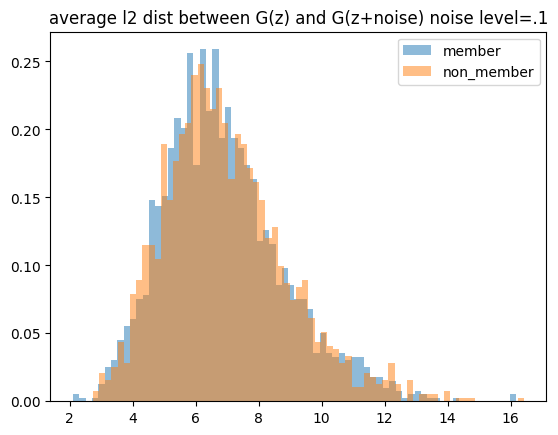

10% 0.4899497487437186
1% 0.525


In [29]:
#stability_member= compute_image_stability(z_member,.1)
#stability_non_member= compute_image_stability(z_non_member,.1)

plt.hist(stability_member, density=True, label='member', alpha=.5, bins=70)
plt.hist(stability_non_member, density=True, label='non_member', alpha=.5, bins=70)
plt.title('average l2 dist between G(z) and G(z+noise) noise level=.1')
plt.legend()
plt.show()

df_member= pd.DataFrame({'stability': stability_member, 'member':[1 for i in range(len(stability_member))]})
df_non_member= pd.DataFrame({'stability': stability_non_member, 'member':[0 for i in range(len(stability_non_member))]})
df= pd.concat([df_member, df_non_member], axis =0, ignore_index=True)
threshold= df.stability.quantile(.1)
print('10%', df.loc[df.stability<= threshold,'member'].mean())
threshold= df.stability.quantile(.01)
print('1%', df.loc[df.stability<= threshold,'member'].mean())

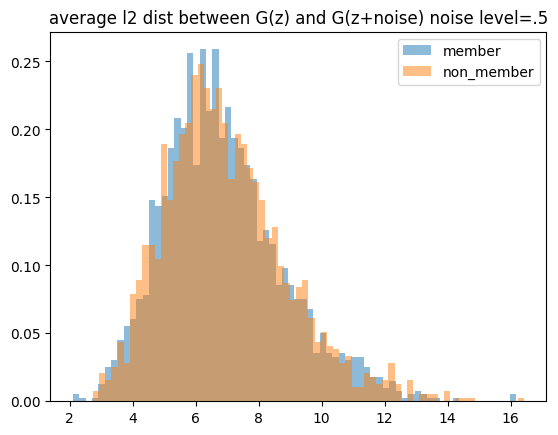

In [28]:
stability_member= compute_image_stability(z_member)
stability_non_member= compute_image_stability(z_non_member)

plt.hist(stability_member, density=True, label='member', alpha=.5, bins=70)
plt.hist(stability_non_member, density=True, label='non_member', alpha=.5, bins=70)
plt.title('average l2 dist between G(z) and G(z+noise) noise level=.5')
plt.legend()
plt.show()

In [30]:
df_member= pd.DataFrame({'stability': stability_member, 'member':[1 for i in range(len(stability_member))]})
df_non_member= pd.DataFrame({'stability': stability_non_member, 'member':[0 for i in range(len(stability_non_member))]})
df= pd.concat([df_member, df_non_member], axis =0, ignore_index=True)
threshold= df.stability.quantile(.1)
print('10%', df.loc[df.stability<= threshold,'member'].mean())
threshold= df.stability.quantile(.01)
print('1%', df.loc[df.stability<= threshold,'member'].mean())

10% 0.4899497487437186
1% 0.525


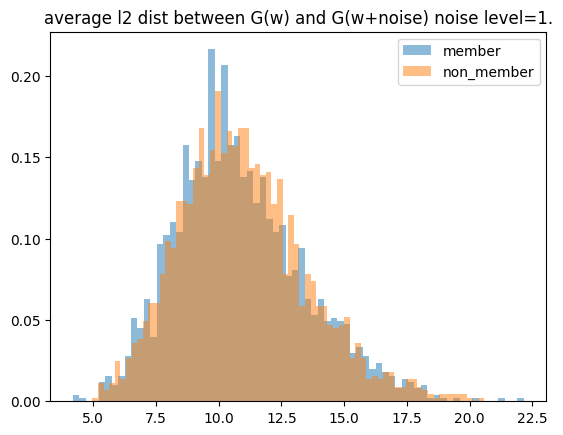

10% 0.5301507537688442
1% 0.525


In [19]:
stability_member= compute_image_stability(z_member,1.)
stability_non_member= compute_image_stability(z_non_member,1.)

plt.hist(stability_member, density=True, label='member', alpha=.5, bins=70)
plt.hist(stability_non_member, density=True, label='non_member', alpha=.5, bins=70)
plt.title('average l2 dist between G(w) and G(w+noise) noise level=1.')
plt.legend()
plt.show()

df_member= pd.DataFrame({'stability': stability_member, 'member':[1 for i in range(len(stability_member))]})
df_non_member= pd.DataFrame({'stability': stability_non_member, 'member':[0 for i in range(len(stability_non_member))]})
df= pd.concat([df_member, df_non_member], axis =0, ignore_index=True)
threshold= df.stability.quantile(.1)
threshold= df.stability.quantile(.1)
print('10%', df.loc[df.stability<= threshold,'member'].mean())
threshold= df.stability.quantile(.01)
print('1%', df.loc[df.stability<= threshold,'member'].mean())

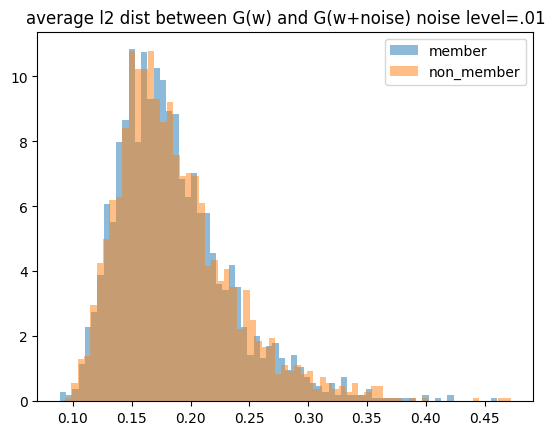

10% 0.5050251256281407
1% 0.475


In [20]:
stability_member= compute_image_stability(z_member,.01)
stability_non_member= compute_image_stability(z_non_member,.01)

plt.hist(stability_member, density=True, label='member', alpha=.5, bins=70)
plt.hist(stability_non_member, density=True, label='non_member', alpha=.5, bins=70)
plt.title('average l2 dist between G(w) and G(w+noise) noise level=.01')
plt.legend()
plt.show()

df_member= pd.DataFrame({'stability': stability_member, 'member':[1 for i in range(len(stability_member))]})
df_non_member= pd.DataFrame({'stability': stability_non_member, 'member':[0 for i in range(len(stability_non_member))]})
df= pd.concat([df_member, df_non_member], axis =0, ignore_index=True)
threshold= df.stability.quantile(.1)
print('10%', df.loc[df.stability<= threshold,'member'].mean())
threshold= df.stability.quantile(.01)
print('1%', df.loc[df.stability<= threshold,'member'].mean())

In [23]:
len(stability_non_member)

2000